In [130]:
%matplotlib inline
# library imports
import numpy as np
import pandas as pd
import os
import bz2

In [131]:
# get the input data
print(os.listdir("./input"))

bzfile = bz2.BZ2File('./input/test.ft.txt.bz2','r')
lines = bzfile.readlines()

print(lines[1])

['test.ft.txt.bz2', 'train.ft.txt.bz2']
b"__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it.\n"


In [132]:
sentimentlist = []
def splitdocs(docs,splitstr = '__label__'):
    for i in range(len(docs)):
        linetext = str(lines[i])
        splittedtext = linetext.split(splitstr)
        RHStext = splittedtext[1]
        sentiment = RHStext[0]
        n = len(RHStext)
        reviewtext = RHStext[2:n-1]
        sentimentlist.append([reviewtext,sentiment])
    print("done successfully")
        
    return sentimentlist

In [133]:
print(len(lines))
computedsentimentlist = []
computedsentimentlist = splitdocs(lines)

400000
done successfully


In [134]:
train_dataset = pd.DataFrame(computedsentimentlist,columns=['ReviewText','sentiment'])
train_dataset.head()

,ReviewText,sentiment
0,Great CD: My lovely Pat has one of the GREAT v...,2
1,One of the best game music soundtracks - for a...,2
2,Batteries died within a year ...: I bought thi...,1
3,"works fine, but Maha Energy is better: Check o...",2
4,Great for the non-audiophile: Reviewed quite a...,2


In [135]:
# convert
train_dataset['sentiment'][train_dataset['sentiment']=='1'] = 0
train_dataset['sentiment'][train_dataset['sentiment']=='2'] = 1
train_dataset.head()

,ReviewText,sentiment
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [136]:
train_dataset['word_count'] = train_dataset['ReviewText'].str.lower().str.split(' ').apply(len)
train_dataset.head()

,ReviewText,sentiment,word_count
0,Great CD: My lovely Pat has one of the GREAT v...,1,106
1,One of the best game music soundtracks - for a...,1,148
2,Batteries died within a year ...: I bought thi...,0,60
3,"works fine, but Maha Energy is better: Check o...",1,37
4,Great for the non-audiophile: Reviewed quite a...,1,69


In [137]:
import string 
def remove_punctuations(str1):
    table = str.maketrans({key: None for key in string.punctuation})
    return str1.translate(table)
train_dataset['ReviewText'] = train_dataset['ReviewText'].apply(remove_punctuations)
train_dataset.head()

,ReviewText,sentiment,word_count
0,Great CD My lovely Pat has one of the GREAT vo...,1,106
1,One of the best game music soundtracks for a ...,1,148
2,Batteries died within a year I bought this ch...,0,60
3,works fine but Maha Energy is better Check out...,1,37
4,Great for the nonaudiophile Reviewed quite a b...,1,69


In [138]:
train_dataset = train_dataset[train_dataset.word_count < 25]  
train_dataset.head()

,ReviewText,sentiment,word_count
20,Long and boring Ive read this book with much e...,0,19
44,Amazing love itvery touchits to bad that in th...,1,15
55,No another grill like this This grill is one o...,1,24
88,Creepy The creepiest book Ive ever read Its a ...,1,22
99,Possibly the funniest movie ever made It start...,1,22


In [150]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = st_wd,min_df=.0001,lowercase=1, max_features=500)
transformed_dataset = c_vector.fit_transform(train_dataset['ReviewText'].values).toarray()
features = c_vector.get_feature_names()

In [140]:
from sklearn.model_selection import train_test_split
y = train_dataset['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(transformed_dataset, y, test_size=0.2)

In [141]:
# assign type to class labels
y_train=y_train.astype('int')
y_test=y_test.astype('int')

#converting sparse matrix to dense
#X_train = X_train.todense()
# X_test = X_test.todense()
# X_train.head()

In [142]:
# NAIVE BAYES CLASSIFICATION
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8538332935275854

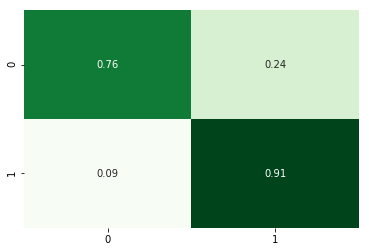

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, cbar=False, annot=True, cmap="Greens", fmt=".2f")
plt.show()

In [144]:
# DECESTION TREE CLASSIFIER
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8012897062335801

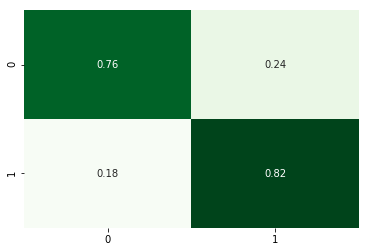

In [145]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, cbar=False, annot=True, cmap="Greens", fmt=".2f")
plt.show()

In [155]:
# export decesion tree
tree.export_graphviz(clf, out_file='tree.dot', max_depth=5, feature_names=features, 
                     proportion=False)